<a href="https://colab.research.google.com/github/LorraineWong/WQD7005-Data-Mining-S2152880/blob/main/WQD7005_Individual_Assignment_S2152880.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **📦 0. Setup and Configuration**

**Step 1:** To configure the development environment and initialize the Azure OpenAI client for prompt-based data generation.

In [32]:
# Install dependencies
!pip install -q openai numpy pandas
!pip install -q ydata-profiling
# Set my working path
my_file_path = "/content/drive/MyDrive/UM Data Science Course Information/WQD7005/"

In [21]:
# Importsimport os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from openai import AzureOpenAI
import random
import time

# Azure endpoint and keys
endpoint = "https://ai-s21528803592ai665634527840.openai.azure.com/"
# model_name = "gpt-4o"
deployment = "gpt-4o"
subscription_key = "6IvEyqI2Yk1OBSBSE4dTAV3n2XXZcP66x3DVRY4lxFVvKpOiFYISJQQJ99BDACHYHv6XJ3w3AAAAACOG8Vsb"
api_version = "2024-12-01-preview"

client = AzureOpenAI(
    api_version=api_version,
    azure_endpoint=endpoint,
    api_key=subscription_key,
)
# Prompt execution wrapper for reuse
def model_prompt(prompt, system_prompt="Act as a professional clinicians.", temperature=0.7, max_tokens=4096):
    response = client.chat.completions.create(
        model=deployment,
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": prompt}
        ],
        max_tokens=max_tokens,
        temperature=temperature,
    )
    return response.choices[0].message.content

**Step 2:** To validate the GPT-4o response format and simulate a single patient's health monitoring record, ensuring the JSON structure meets expectations.

In [22]:
# Single Sample Data Generation via model
data_prompt = """
Generate a single, realistic patient monitoring record for one randomly selected adult patient.

Provide the following fields:
- oxygen_saturation (in %)
- heart_rate (in bpm)
- temperature (in °C)
- blood_pressure (systolic/diastolic, e.g. "120/80")
- weight (in kg)
- blood_glucose (in mg/dL)

At the end, include a brief clinical_note (1–2 sentences, max 30 words) summarizing the patient status based on the values above. Use professional clinical tone with realistic variation (e.g. stable, recovering, mild concerns).

Output as a valid JSON object with keys:
oxygen_saturation, heart_rate, temperature, blood_pressure, weight, blood_glucose, clinical_note.

Constraints:
- Only output one JSON object.
- No markdown or explanation.
- Include realistic variation across different health conditions (e.g. fatigue, post-op, dietary changes, stress).
- Ensure all fields are complete, no missing values.
"""

print(model_prompt(data_prompt))

{
  "oxygen_saturation": 95,
  "heart_rate": 87,
  "temperature": 37.2,
  "blood_pressure": "128/82",
  "weight": 72,
  "blood_glucose": 145,
  "clinical_note": "Patient shows mild hyperglycemia and slightly elevated heart rate, likely related to dietary factors. Overall condition is stable with no immediate concerns."
}


# **🧩 1. Dataset Simulation using GenAI**

This section outlines the full pipeline for generating synthetic patient monitoring data using a GenAI-powered approach. GPT-4o is used to simulate 30-day clinical records per patient in a realistic medical context. The process includes prompt engineering, safe response validation, and structured output storage for further analysis.

**Step 1: Prompt Engineering with Clinical Context**
The prompt defines the required fields (vital signs + clinical note), instructs model on how to simulate recovery trends, controls for missing value logic, and constrains the output to valid JSON without extra formatting.

**Step 2: Generate and Save Raw Outputs**
To generate 30-day clinical data per patient using model and safely store each raw response as .txt for later parsing.

**Step 3: Parse and Build the Final Dataset**
To transform model-generated .txt files into a clean and structured DataFrame, validating JSON format and extracting fields.

**Step 4: Final Export to CSV**
To save the simulated and parsed data in a structured format suitable for downstream analytics and visualization.


In [13]:
import pandas as pd
import numpy as np
import json
import time
import re
import os
import glob

# Configuration
num_patients = 3
start_date_str = "2025-01-01"
raw_output_dir = my_file_path+"raw_outputs"
os.makedirs(raw_output_dir, exist_ok=True)

# === Utility Functions ===
def parse_json_from_prompt(raw_output):
    clean_text = re.sub(r"```json|```", "", raw_output).strip()
    return json.loads(clean_text)

def is_valid_json(text):
    try:
        json.loads(text)
        return True
    except json.JSONDecodeError as e:
        print("JSON error:", e)
        return False

# === Prompt Generator ===
def generate_patient_prompt(patient_id, start_date):
    return f"""
Generate a JSON array of 30 daily monitoring records for patient {patient_id}, starting from {start_date} (YYYY-MM-DD).

Each record must include:
- date
- oxygen_saturation (%)
- heart_rate (bpm)
- temperature (°C)
- blood_pressure ("systolic/diastolic")
- weight (kg)
- blood_glucose (mg/dL)
- clinical_note (1–2 sentences in professional tone, max 35 words)

Instructions:
- Choose a realistic medical scenario (e.g. infection, post-surgery, pregnancy, anxiety, fatigue)
- Simulate realistic changes over 30 days: early-stage symptoms → improvement → stabilization or recovery
- Use only professional clinical language, describing daily changes, recovery, and trends
- Avoid device/system mentions

Missing Data Instructions:
- Omit at most 1 field per day, no more than 3 total days
- Only temperature, weight, and blood_glucose may be missing
- Do not use null/empty values—omit keys entirely

Output only a valid JSON array of 30 objects. No markdown, no code block, no explanation.
"""

# === Phase 1: Generation and Save Raw Output ===
for pid in range(1, num_patients + 1):
    patient_id = f"P{pid:04d}"
    prompt = generate_patient_prompt(patient_id, start_date_str)
    raw_output = model_prompt(prompt)

    with open(f"{raw_output_dir}/data_output_{patient_id}.txt", "w") as f:
        f.write(raw_output)

    print(f"Saved output for patient id: {patient_id}.")
    time.sleep(0.25)

# === Phase 2: Parse Raw Output into DataFrame ===
records = []

for file_path in sorted(glob.glob(f"{raw_output_dir}/data_output_P*.txt")):
    patient_id = os.path.basename(file_path).split("_")[-1].split(".")[0]

    with open(file_path, "r") as f:
        raw_output = f.read()

    if raw_output and is_valid_json(raw_output):
        try:
            daily_data = parse_json_from_prompt(raw_output)
            for day in daily_data:
                records.append({
                    "patient_id": patient_id,
                    "timestamp": day.get("date", np.nan),
                    "oxygen_saturation": day.get("oxygen_saturation", np.nan),
                    "heart_rate": day.get("heart_rate", np.nan),
                    "temperature": day.get("temperature", np.nan),
                    "blood_pressure": day.get("blood_pressure", np.nan),
                    "weight": day.get("weight", np.nan),
                    "blood_glucose": day.get("blood_glucose", np.nan),
                    "clinical_note": day.get("clinical_note", "")
                })
        except Exception as err:
            print(f"Parse error for {patient_id}: {err}")
    else:
        print(f"Skipped {patient_id} due to invalid JSON.")

# Save parsed dataset
df = pd.DataFrame(records)
df.to_csv(my_file_path+"generate_patient_dataset.csv", index=False)
df.head()


Saved GPT output for P0001
Saved GPT output for P0002
Saved GPT output for P0003


,patient_id,timestamp,oxygen_saturation,heart_rate,temperature,blood_pressure,weight,blood_glucose,clinical_note
0,P0001,2025-01-01,94,108,38.2,140/90,72.5,160.0,"Patient presents with fatigue, elevated temper..."
1,P0001,2025-01-02,93,110,38.5,142/92,72.4,165.0,Symptoms persist with mild respiratory distres...
2,P0001,2025-01-03,92,112,NaN,145/94,72.3,170.0,Respiratory effort remains elevated; temperatu...
3,P0001,2025-01-04,91,115,39.0,148/96,72.2,NaN,"Signs of worsening infection; fever persists, ..."
4,P0001,2025-01-05,93,110,38.8,145/92,72.2,160.0,Early signs of improvement noted after antibio...


# **📊 2. Exploratory Data Analysis (EDA) Enhanced by LLMs**

This section combines automated statistical profiling and clinical interpretation powered by GPT-4o to satisfy both data visualization and language model-enhanced exploration as required by the assignment.

**Step 1: Load and Preview the Dataset**

Read the previously saved CSV, convert the timestamp to datetime format, and perform a quick inspection of the dataset shape and features.

In [25]:
import pandas as pd

# Load the dataset
df = pd.read_csv(my_file_path + "genai_patient_dataset.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"])

# Preview structure
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   patient_id         90 non-null     object        
 1   timestamp          90 non-null     datetime64[ns]
 2   oxygen_saturation  90 non-null     int64         
 3   heart_rate         90 non-null     int64         
 4   temperature        73 non-null     float64       
 5   blood_pressure     90 non-null     object        
 6   weight             83 non-null     float64       
 7   blood_glucose      60 non-null     float64       
 8   clinical_note      90 non-null     object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 6.5+ KB


,patient_id,timestamp,oxygen_saturation,heart_rate,temperature,blood_pressure,weight,blood_glucose,clinical_note
0,P0001,2025-01-01,94,108,38.2,140/90,72.5,160.0,"Patient presents with fatigue, elevated temper..."
1,P0001,2025-01-02,93,110,38.5,142/92,72.4,165.0,Symptoms persist with mild respiratory distres...
2,P0001,2025-01-03,92,112,NaN,145/94,72.3,170.0,Respiratory effort remains elevated; temperatu...
3,P0001,2025-01-04,91,115,39.0,148/96,72.2,NaN,"Signs of worsening infection; fever persists, ..."
4,P0001,2025-01-05,93,110,38.8,145/92,72.2,160.0,Early signs of improvement noted after antibio...


**Step 2: Automated Full EDA with ydata-profiling**

Using ydata-profiling to a comprehensive and professional-grade EDA report covering data types, statistics, missing values, correlations, interactions, distributions, and more.

In [35]:
from ydata_profiling import ProfileReport
from IPython.core.display import display, HTML

# Generate profiling report
profile = ProfileReport(df, title="GenAI Patient Dataset Exploratory Data Analysis (EDA)", explorative=True)
profile.to_file("eda_patient_report.html")

# Display in notebook
# with open("eda_patient_report.html", "r") as f:
#     display(HTML(f.read()))

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 9/9 [00:00<00:00, 10399.10it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [26]:
# Calculate missing counts and percentages
missing_summary = df.isna().sum().to_frame(name="Missing Count")
missing_summary["Missing %"] = (missing_summary["Missing Count"] / len(df)) * 100
print(missing_summary)

                   Missing Count  Missing %
patient_id                     0   0.000000
timestamp                      0   0.000000
oxygen_saturation              0   0.000000
heart_rate                     0   0.000000
temperature                   17  18.888889
blood_pressure                 0   0.000000
weight                         7   7.777778
blood_glucose                 30  33.333333
clinical_note                  0   0.000000


**Step 3: Time Series Trend Visualization**

Generate line plots for temperature, heart_rate, and blood_glucose, grouped by patient_id, to reveal trends, anomalies, or patterns of recovery.

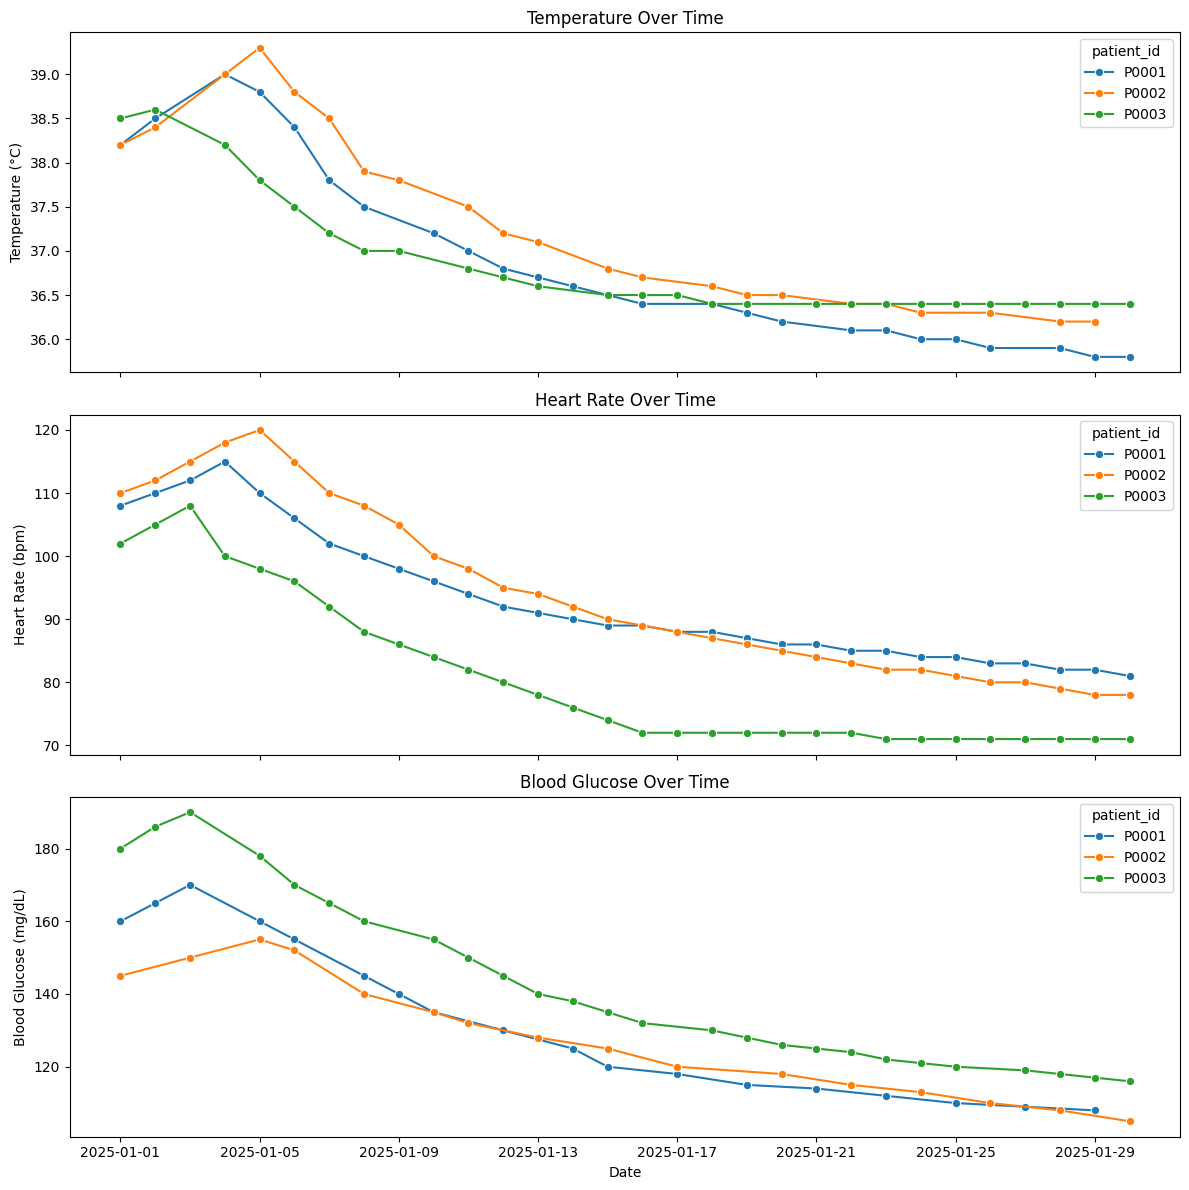

In [28]:
fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

# Temperature
sns.lineplot(ax=axes[0], data=df, x="timestamp", y="temperature", hue="patient_id", marker="o")
axes[0].set_title("Temperature Over Time")
axes[0].set_ylabel("Temperature (°C)")

# Heart Rate
sns.lineplot(ax=axes[1], data=df, x="timestamp", y="heart_rate", hue="patient_id", marker="o")
axes[1].set_title("Heart Rate Over Time")
axes[1].set_ylabel("Heart Rate (bpm)")

# Blood Glucose
sns.lineplot(ax=axes[2], data=df, x="timestamp", y="blood_glucose", hue="patient_id", marker="o")
axes[2].set_title("Blood Glucose Over Time")
axes[2].set_ylabel("Blood Glucose (mg/dL)")
axes[2].set_xlabel("Date")

plt.tight_layout()
plt.show()

**Step 4: LLMs-Based Trend Summarization**

To leverage LLMs (GPT-4o) for automated summarization of clinical trends over the 30-day period for each patient.

In [29]:
# Combine daily notes per patient
patient_notes = df.groupby("patient_id")["clinical_note"].apply(lambda x: "\n".join(x)).reset_index()
patient_notes.columns = ["patient_id", "all_notes"]

# Generate summarization prompt
def generate_summary_prompt(pid, notes):
    return f"""Summarize the 30-day clinical trend of patient {pid} based on the following daily notes:

{notes}

Write a 2–3 sentence summary in professional clinical tone, highlighting initial state, symptoms, changes, recovery, and final status.
"""

summary_prompts = patient_notes.apply(lambda row: generate_summary_prompt(row["patient_id"], row["all_notes"]), axis=1)

In [30]:
# Generate GPT-4 summaries
summaries = []
for idx, prompt in summary_prompts.items():
    output = model_prompt(prompt)  # Your GPT-4o wrapper
    summaries.append({
        "patient_id": patient_notes.loc[idx, "patient_id"],
        "summary": output
    })

# Save and display results
summary_df = pd.DataFrame(summaries)
summary_df.to_csv(my_file_path + "gpt_summary_output.csv", index=False)
summary_df

,patient_id,summary
0,P0001,Patient P0001 initially presented with fatigue...
1,P0002,"Over the 30-day clinical course, patient P0002..."
2,P0003,"Over the 30-day clinical course, patient P0003..."


# **🧼 3. Advanced Data Preprocessing with SLMs / LLMs**

# **📝 4. AI-Assisted Summary Report and Visualization**